In [1]:
import numpy as np
import skimage.io
from scipy.ndimage import zoom
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
## Pre-processing, copy from caffe.io

class Transformer:
    """
    Transform input for feeding into a Net.

    Note: this is mostly for illustrative purposes and it is likely better
    to define your own input preprocessing routine for your needs.

    Parameters
    ----------
    net : a Net for which the input should be prepared
    """
    def __init__(self, inputs):
        self.inputs = inputs
        self.transpose = {}
        self.channel_swap = {}
        self.raw_scale = {}
        self.mean = {}
        self.input_scale = {}

    def __check_input(self, in_):
        if in_ not in self.inputs:
            raise Exception('{} is not one of the net inputs: {}'.format(
                in_, self.inputs))

    def preprocess(self, in_, data):
        """
        Format input for Caffe:
        - convert to single
        - resize to input dimensions (preserving number of channels)
        - transpose dimensions to K x H x W
        - reorder channels (for instance color to BGR)
        - scale raw input (e.g. from [0, 1] to [0, 255] for ImageNet models)
        - subtract mean
        - scale feature

        Parameters
        ----------
        in_ : name of input blob to preprocess for
        data : (H' x W' x K) ndarray

        Returns
        -------
        caffe_in : (K x H x W) ndarray for input to a Net
        """
        self.__check_input(in_)
        caffe_in = data.astype(np.float32, copy=False)
        transpose = self.transpose.get(in_)
        channel_swap = self.channel_swap.get(in_)
        raw_scale = self.raw_scale.get(in_)
        mean = self.mean.get(in_)
        input_scale = self.input_scale.get(in_)
        in_dims = self.inputs[in_][2:]
        if caffe_in.shape[:2] != in_dims:
            caffe_in = resize_image(caffe_in, in_dims)
        if transpose is not None:
            caffe_in = caffe_in.transpose(transpose)
        if channel_swap is not None:
            caffe_in = caffe_in[channel_swap, :, :]
        if raw_scale is not None:
            caffe_in *= raw_scale
        if mean is not None:
            caffe_in -= mean
        if input_scale is not None:
            caffe_in *= input_scale
        return caffe_in

    def deprocess(self, in_, data):
        """
        Invert Caffe formatting; see preprocess().
        """
        self.__check_input(in_)
        decaf_in = data.copy().squeeze()
        transpose = self.transpose.get(in_)
        channel_swap = self.channel_swap.get(in_)
        raw_scale = self.raw_scale.get(in_)
        mean = self.mean.get(in_)
        input_scale = self.input_scale.get(in_)
        if input_scale is not None:
            decaf_in /= input_scale
        if mean is not None:
            decaf_in += mean
        if raw_scale is not None:
            decaf_in /= raw_scale
        if channel_swap is not None:
            decaf_in = decaf_in[np.argsort(channel_swap), :, :]
        if transpose is not None:
            decaf_in = decaf_in.transpose(np.argsort(transpose))
        return decaf_in

    def set_transpose(self, in_, order):
        """
        Set the input channel order for e.g. RGB to BGR conversion
        as needed for the reference ImageNet model.

        Parameters
        ----------
        in_ : which input to assign this channel order
        order : the order to transpose the dimensions
        """
        self.__check_input(in_)
        if len(order) != len(self.inputs[in_]) - 1:
            raise Exception('Transpose order needs to have the same number of '
                            'dimensions as the input.')
        self.transpose[in_] = order

    def set_channel_swap(self, in_, order):
        """
        Set the input channel order for e.g. RGB to BGR conversion
        as needed for the reference ImageNet model.
        N.B. this assumes the channels are the first dimension AFTER transpose.

        Parameters
        ----------
        in_ : which input to assign this channel order
        order : the order to take the channels.
            (2,1,0) maps RGB to BGR for example.
        """
        self.__check_input(in_)
        if len(order) != self.inputs[in_][1]:
            raise Exception('Channel swap needs to have the same number of '
                            'dimensions as the input channels.')
        self.channel_swap[in_] = order

    def set_raw_scale(self, in_, scale):
        """
        Set the scale of raw features s.t. the input blob = input * scale.
        While Python represents images in [0, 1], certain Caffe models
        like CaffeNet and AlexNet represent images in [0, 255] so the raw_scale
        of these models must be 255.

        Parameters
        ----------
        in_ : which input to assign this scale factor
        scale : scale coefficient
        """
        self.__check_input(in_)
        self.raw_scale[in_] = scale

    def set_mean(self, in_, mean):
        """
        Set the mean to subtract for centering the data.

        Parameters
        ----------
        in_ : which input to assign this mean.
        mean : mean ndarray (input dimensional or broadcastable)
        """
        self.__check_input(in_)
        ms = mean.shape
        if mean.ndim == 1:
            # broadcast channels
            if ms[0] != self.inputs[in_][1]:
                raise ValueError('Mean channels incompatible with input.')
            mean = mean[:, np.newaxis, np.newaxis]
        else:
            # elementwise mean
            if len(ms) == 2:
                ms = (1,) + ms
            if len(ms) != 3:
                raise ValueError('Mean shape invalid')
            if ms != self.inputs[in_][1:]:
                raise ValueError('Mean shape incompatible with input shape.')
        self.mean[in_] = mean

    def set_input_scale(self, in_, scale):
        """
        Set the scale of preprocessed inputs s.t. the blob = blob * scale.
        N.B. input_scale is done AFTER mean subtraction and other preprocessing
        while raw_scale is done BEFORE.

        Parameters
        ----------
        in_ : which input to assign this scale factor
        scale : scale coefficient
        """
        self.__check_input(in_)
        self.input_scale[in_] = scale

def resize_image(im, new_dims, interp_order=1):
    """
    Resize an image array with interpolation.

    Parameters
    ----------
    im : (H x W x K) ndarray
    new_dims : (height, width) tuple of new dimensions.
    interp_order : interpolation order, default is linear.

    Returns
    -------
    im : resized ndarray with shape (new_dims[0], new_dims[1], K)
    """
    if im.shape[-1] == 1 or im.shape[-1] == 3:
        im_min, im_max = im.min(), im.max()
        if im_max > im_min:
            # skimage is fast but only understands {1,3} channel images
            # in [0, 1].
            im_std = (im - im_min) / (im_max - im_min)
            resized_std = resize(im_std, new_dims, order=interp_order)
            resized_im = resized_std * (im_max - im_min) + im_min
        else:
            # the image is a constant -- avoid divide by 0
            ret = np.empty((new_dims[0], new_dims[1], im.shape[-1]),
                           dtype=np.float32)
            ret.fill(im_min)
            return ret
    else:
        # ndimage interpolates anything but more slowly.
        scale = tuple(np.array(new_dims, dtype=float) / np.array(im.shape[:2]))
        resized_im = zoom(im, scale + (1,), order=interp_order)
    return resized_im.astype(np.float32)

## Image IO

def load_image(filename, color=True):
    """
    Load an image converting from grayscale or alpha as needed.

    Parameters
    ----------
    filename : string
    color : boolean
        flag for color format. True (default) loads as RGB while False
        loads as intensity (if image is already grayscale).

    Returns
    -------
    image : an image with type np.float32 in range [0, 1]
        of size (H x W x 3) in RGB or
        of size (H x W x 1) in grayscale.
    """
    img = skimage.img_as_float(skimage.io.imread(filename, as_grey=not color)).astype(np.float32)
    if img.ndim == 2:
        img = img[:, :, np.newaxis]
        if color:
            img = np.tile(img, (1, 1, 3))
    elif img.shape[2] == 4:
        img = img[:, :, :3]
    return img

In [3]:
transformer = Transformer({'data': (1, 3, 300, 300)})
transformer.set_transpose('data', (2, 0, 1))
transformer.set_mean('data', np.array([104,117,123])) # mean pixel
transformer.set_raw_scale('data', 255)
transformer.set_channel_swap('data', (2,1,0))
image_resize = 300

#image = load_image('./cat.jpg')
image = load_image('./fish-bike.jpg')

transformed_image = transformer.preprocess('data', image)

In [4]:
from caffe2.proto import caffe2_pb2
from caffe2.python import workspace, core

def deviceOpts(cpu_or_cuda):
    device_opts = caffe2_pb2.DeviceOption()
    if cpu_or_cuda == 'cpu':
        device_opts.device_type = caffe2_pb2.CPU
    elif cpu_or_cuda == 'cuda':
        device_opts.device_type = caffe2_pb2.CUDA
        device_opts.cuda_gpu_id = 0
    return device_opts

_devs = {'CUDA': deviceOpts('cuda'), 'CPU': deviceOpts('cpu')}

def initNet(init_net_path):
    init_def = caffe2_pb2.NetDef()
    with open(init_net_path, 'r') as f:
        init_def.ParseFromString(f.read())
        init_def.device_option.CopyFrom(_devs['CUDA'])
        workspace.RunNetOnce(init_def)
    return init_def
        
def createNet(predict_net_path):
    net_def = caffe2_pb2.NetDef()
    with open(predict_net_path, 'r') as f:
        net_def.ParseFromString(f.read())
        for op in net_def.op:
            if op.type == 'PriorBox':
                op.device_option.CopyFrom(_devs['CUDA'])
            elif op.type == 'Concat' and op.output[0] == 'mbox_priorbox':
          #      op.arg.axis=
                op.device_option.CopyFrom(_devs['CPU'])
            elif op.type == 'Norm':
                op.device_option.CopyFrom(_devs['CUDA'])
            elif op.type == 'DetectionOutput':
                op.device_option.CopyFrom(_devs['CUDA'])
            else:
                op.device_option.CopyFrom(_devs['CUDA'])
                op.engine = 'CUDNN'
    workspace.CreateNet(net_def, overwrite=True)
    return net_def

In [4]:
from caffe2.proto import caffe2_pb2
from caffe2.python import workspace, core

def deviceOpts(cpu_or_cuda):
    device_opts = caffe2_pb2.DeviceOption()
    if cpu_or_cuda == 'cpu':
        device_opts.device_type = caffe2_pb2.CPU
    elif cpu_or_cuda == 'cuda':
        device_opts.device_type = caffe2_pb2.CUDA
        device_opts.cuda_gpu_id = 0
    return device_opts

_devs = {'CUDA': deviceOpts('cuda'), 'CPU': deviceOpts('cpu')}

def initNet(init_net_path):
    init_def = caffe2_pb2.NetDef()
    with open(init_net_path, 'r') as f:
        init_def.ParseFromString(f.read())
        init_def.device_option.CopyFrom(_devs['CPU'])
        workspace.RunNetOnce(init_def)
    return init_def
        
def createNet(predict_net_path):
    net_def = caffe2_pb2.NetDef()
    with open(predict_net_path, 'r') as f:
        net_def.ParseFromString(f.read())
        for op in net_def.op:
            if op.type == 'PriorBox':
                op.device_option.CopyFrom(_devs['CPU'])
            elif op.type == 'Concat' and op.output[0] == 'mbox_priorbox':
          #      op.arg.axis=
                op.device_option.CopyFrom(_devs['CPU'])
            elif op.type == 'Norm':
                op.device_option.CopyFrom(_devs['CPU'])
            elif op.type == 'DetectionOutput':
                op.device_option.CopyFrom(_devs['CPU'])
            else:
                op.device_option.CopyFrom(_devs['CPU'])
            #    op.engine = 'CUDNN'
    workspace.CreateNet(net_def, overwrite=True)
    return net_def

In [5]:
init_net = '/home/ernie/caffemodel/VGG_VOC0712_SSD_300x300_ft_iter_120000_model.pb'
pred_net = '/home/ernie/caffemodel/VGG_VOC0712_SSD_300x300_ft_iter_120000_deploy.pb'

#init_net = './VGG_VOC0712Plus_SSD_300x300_ft_iter_160000_model.pb'
#pred_net = './VGG_VOC0712Plus_SSD_300x300_ft_iter_160000_deploy.pb'

init_def = initNet(init_net)
net_def = createNet(pred_net)

In [6]:
for op in net_def.op:
    print op

input: "data"
input: "conv1_1_w"
input: "conv1_1_b"
output: "conv1_1"
type: "Conv"
arg {
  name: "stride"
  i: 1
}
arg {
  name: "pad"
  i: 1
}
arg {
  name: "kernel"
  i: 3
}
device_option {
  device_type: 1
  cuda_gpu_id: 0
}
engine: "CUDNN"

input: "conv1_1"
output: "conv1_1"
type: "Relu"
device_option {
  device_type: 1
  cuda_gpu_id: 0
}
engine: "CUDNN"

input: "conv1_1"
input: "conv1_2_w"
input: "conv1_2_b"
output: "conv1_2"
type: "Conv"
arg {
  name: "stride"
  i: 1
}
arg {
  name: "pad"
  i: 1
}
arg {
  name: "kernel"
  i: 3
}
device_option {
  device_type: 1
  cuda_gpu_id: 0
}
engine: "CUDNN"

input: "conv1_2"
output: "conv1_2"
type: "Relu"
device_option {
  device_type: 1
  cuda_gpu_id: 0
}
engine: "CUDNN"

input: "conv1_2"
output: "pool1"
type: "MaxPool"
arg {
  name: "stride"
  i: 2
}
arg {
  name: "pad"
  i: 0
}
arg {
  name: "kernel"
  i: 2
}
arg {
  name: "order"
  s: "NCHW"
}
arg {
  name: "legacy_pad"
  i: 3
}
device_option {
  device_type: 1
  cuda_gpu_id: 0
}
engine:

In [6]:
workspace.FeedBlob('data', transformed_image[np.newaxis, :, :, :], _devs['CUDA'])
workspace.RunNet(net_def.name, 1)

detections = workspace.FetchBlob('detection_out')
print detections

[[[[  0.00000000e+00   1.00000000e+00   7.86574930e-02 ...,
      2.05113720e-02   8.31032991e-02   8.01430643e-02]
   [  0.00000000e+00   1.00000000e+00   1.64706912e-02 ...,
      3.03485915e-02   7.54577816e-02   7.20587969e-02]
   [  0.00000000e+00   1.00000000e+00   1.47346295e-02 ...,
      2.01304834e-02   1.12290844e-01   6.52017072e-02]
   ..., 
   [  0.00000000e+00   1.50000000e+01   1.05315233e-02 ...,
      1.21032976e-01   7.06807613e-01   1.55354097e-01]
   [  0.00000000e+00   1.50000000e+01   1.05092023e-02 ...,
      5.93704768e-02   4.83073622e-01   8.41856897e-02]
   [  0.00000000e+00   1.50000000e+01   1.05082989e-02 ...,
      6.94433525e-02   2.89754927e-01   9.43921879e-02]]]]


In [6]:
workspace.FeedBlob('data', transformed_image[np.newaxis, :, :, :], _devs['CPU'])
workspace.RunNet(net_def.name, 1)

detections = workspace.FetchBlob('detection_out')
print detections

[[[[  0.00000000e+00   1.00000000e+00   7.86576048e-02 ...,
      2.05113888e-02   8.31032842e-02   8.01430866e-02]
   [  0.00000000e+00   1.00000000e+00   1.64706744e-02 ...,
      3.03485990e-02   7.54577741e-02   7.20587969e-02]
   [  0.00000000e+00   1.00000000e+00   1.47346416e-02 ...,
      2.01305021e-02   1.12290815e-01   6.52016923e-02]
   ..., 
   [  0.00000000e+00   1.50000000e+01   1.05315335e-02 ...,
      1.21032976e-01   7.06807613e-01   1.55354083e-01]
   [  0.00000000e+00   1.50000000e+01   1.05091929e-02 ...,
      5.93704693e-02   4.83073622e-01   8.41856748e-02]
   [  0.00000000e+00   1.50000000e+01   1.05082840e-02 ...,
      6.94433525e-02   2.89754927e-01   9.43921879e-02]]]]


In [7]:
# Parse the outputs.
det_label = detections[0,0,:,1]
det_conf = detections[0,0,:,2]
det_xmin = detections[0,0,:,3]
det_ymin = detections[0,0,:,4]
det_xmax = detections[0,0,:,5]
det_ymax = detections[0,0,:,6]

# Get detections with confidence higher than 0.6.
top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]

top_conf = det_conf[top_indices]
top_label_indices = det_label[top_indices].tolist()
top_xmin = det_xmin[top_indices]
top_ymin = det_ymin[top_indices]
top_xmax = det_xmax[top_indices]
top_ymax = det_ymax[top_indices]

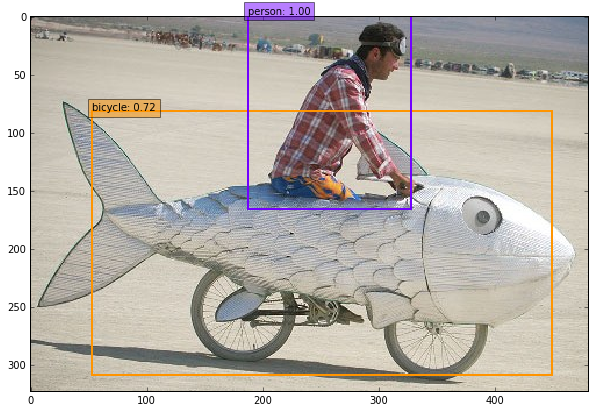

In [8]:
CLASSES = ('__background__', 
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')

plt.imshow(image)
currentAxis = plt.gca()
colors = plt.cm.hsv(np.linspace(0, 1, len(CLASSES))).tolist()

for i in xrange(top_conf.shape[0]):
    xmin = int(round(top_xmin[i] * image.shape[1]))
    ymin = int(round(top_ymin[i] * image.shape[0]))
    xmax = int(round(top_xmax[i] * image.shape[1]))
    ymax = int(round(top_ymax[i] * image.shape[0]))
    score = top_conf[i]
    label = int(top_label_indices[i])
    display_txt = '%s: %.2f'%(CLASSES[label], score)
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    color = colors[label]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})

In [9]:
mbox_loc = workspace.FetchBlob('mbox_loc')
print mbox_loc.max()

mbox_conf_flatten = workspace.FetchBlob('mbox_conf_flatten')
print mbox_conf_flatten.sum()

mbox_priorbox = workspace.FetchBlob('mbox_priorbox')
print mbox_priorbox.max()

4.14239
8732.0
1.36765


In [7]:
#gpu
import time
start = time.time()
for i in range(1000):
    workspace.RunNet(net_def.name, 1)
end = time.time()
print "runing time is {:.3f}".format((end - start) / 1000.)

runing time is 0.045


In [7]:
#cpu
import time
start = time.time()
for i in range(100):
    workspace.RunNet(net_def.name, 1)
end = time.time()
print "runing time is {:.3f}".format((end - start) / 100.)

runing time is 1.579


In [11]:
import caffe2.python._import_c_extension as C

C.benchmark_net(net_def.name, 0, 10, True)

[1204.3927001953125,
 17.23080825805664,
 2.1608669757843018,
 215.52005004882812,
 2.2729604244232178,
 24.64541244506836,
 56.48329544067383,
 0.8968822360038757,
 109.0723648071289,
 0.8681319355964661,
 9.863080024719238,
 44.428184509277344,
 0.3738452196121216,
 85.12112426757812,
 0.3563707768917084,
 87.4424057006836,
 0.36319470405578613,
 4.263047218322754,
 55.59812545776367,
 0.19033069908618927,
 76.17935180664062,
 0.1895279884338379,
 74.21733093261719,
 0.18996188044548035,
 2.2981607913970947,
 18.95724868774414,
 0.06554689258337021,
 19.408382415771484,
 0.0650063008069992,
 19.475778579711914,
 0.0647967979311943,
 3.281628370285034,
 34.767948150634766,
 0.11066349595785141,
 7.78586483001709,
 0.11033479869365692,
 2.3323285579681396,
 0.03309649974107742,
 2.9369709491729736,
 0.019037101417779922,
 0.27888742089271545,
 0.004616000223904848,
 1.247251033782959,
 0.002794099971652031,
 0.06857330352067947,
 0.0012369999894872308,
 4.4961652755737305,
 0.001491000